In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from argparse import Namespace
import misc.logging_utils as logging_utils

args = Namespace()
logger = logging_utils.get_ipython_logger()

# in case we distribute to a dask cluster
from joblib import parallel_backend
import distributed.joblib
import misc.dask_utils as dask_utils

dask_utils.add_dask_values_to_args(args, cluster_location="LOCAL", num_cpus=3, num_threads_per_cpu=1)
client, cluster = dask_utils.connect(args)

# standard pydata imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set(style='white', color_codes=True)

INFO     : [dask_utils]: starting local dask cluster


In [2]:
import fancyimpute
import numpy as np
import pandas as pd


import autosklearn.classification
import autosklearn.pipeline.classification
import sklearn.datasets
import sklearn.model_selection

import sklearn.metrics

import automlutils.asl_fancyimpute
import misc.math_utils as math_utils
import misc.mpl_utils as mpl_utils
import more_itertools

from automlutils.autosklearn_wrapper import AutoSklearnWrapper
import automlutils.automl_command_line_utils as clu

/home/nle5231/.virtualenvs/keras-test/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
DEBUG    : [utils.get_type]: could not parse type: int


In [3]:
import collections

incomplete_dataset_fields = (
    "X_train_complete",
    "X_train_incomplete",
    "X_test_complete",
    "X_test_incomplete",
    "y_train",
    "y_test"
)
incomplete_dataset_fields = ' '.join(incomplete_dataset_fields)
IncompleteDataset = collections.namedtuple("IncompleteDataset", incomplete_dataset_fields)

def get_mcar_incomplete_data(X, y, fold=0, num_folds=5, missing_likelihood=0.1, random_state=8675309):
    """ Split the dataset and remove some of the observations
    
    Internally, this function uses an MCAR mechanism to remove the data.
    
    Parameters
    ----------
    X: data matrix
        A data matrix suitable for sklearn
        
    y: target variables
        The target variables corresponding to X
        
    fold: int
        The cv fold to return
        
    num_folds: int
        The number of cv folds to create
        
    missing_likelihood: float
        The likelihood each observation in the training data will be missing
        
    random_state: int
        An attempt to make things reproducible
        
    Returns (as a named tuple)
    -------
    X_train_complete: data matrix
        The complete training data for this fold
        
    X_train_incomplete: data matrix
        The incomplete training data for this fold
        
    X_test_complete: data matrix
        The complete testing data for this fold
        
    X_test_incomplete: data matrix
        The incomplete testing data for this fold
        
    y_train: target variables
        The (complete) training target data for this fold
        
    y_test: target variables
        The (complete) testing target data for this fold
    """
    cv = sklearn.model_selection.StratifiedKFold(
        num_folds, random_state=random_state
    )

    splits = cv.split(X, y)
    train, test = more_itertools.nth(splits, fold) # would really use more_itertools.nth

    X_train, y_train = X[train], y[train]
    X_test, y_test = X[test], y[test]

    
    X_incomplete_train, missing_mask = math_utils.mask_random_values(
        X_train,
        likelihood=missing_likelihood,
        return_mask=True,
        random_state=random_state
    )
    
    X_incomplete_test, missing_mask = math_utils.mask_random_values(
        X_test,
        likelihood=missing_likelihood,
        return_mask=True,
        random_state=random_state
    )
    
    ret = IncompleteDataset(
        X_train,
        X_incomplete_train,
        X_test,
        X_incomplete_test,
        y_train,
        y_test
    )
    
    return ret   
    

In [4]:
def get_classification_knn_pipeline(self):
    from automlutils.asl_fancyimpute import ImputerChoice
    
    from autosklearn.pipeline.components import classification as \
        classification_components
    from autosklearn.pipeline.components.data_preprocessing import rescaling as \
        rescaling_components
    from autosklearn.pipeline.components.data_preprocessing.balancing.balancing import \
        Balancing
    from autosklearn.pipeline.components.data_preprocessing.one_hot_encoding\
        .one_hot_encoding import OneHotEncoder
    from autosklearn.pipeline.components import feature_preprocessing as \
        feature_preprocessing_components

    steps = []

    default_dataset_properties = {'target_type': 'classification'}

    steps.extend(
        [["one_hot_encoding", OneHotEncoder()],
         #["impute", ImputerChoice(default_dataset_properties)],
         ["impute", automlutils.asl_fancyimpute.knn.KNN()],
         ["rescaling",
          rescaling_components.RescalingChoice(default_dataset_properties)],
         ["balancing", Balancing()]])

    # Add the preprocessing component
    steps.append(['preprocessor',
                  feature_preprocessing_components.FeaturePreprocessorChoice(
                      default_dataset_properties)])

    # Add the classification component
    steps.append(['classifier',
                  classification_components.ClassifierChoice(
                      default_dataset_properties)])
    
    return steps

In [5]:
clu.add_automl_values_to_args(args, total_training_time=30)

X, y = sklearn.datasets.load_iris(return_X_y=True)
data = get_mcar_incomplete_data(X, y)

In [6]:
asl_classifier = AutoSklearnWrapper(
    args=args,
    custom_pipeline=get_classification_knn_pipeline,
    estimator_named_step='classifier'    
)

DEBUG    : [asl_wrapper]: initializing a wrapper. ensemble: None. autosklearn: None


In [7]:
asl_classifier_fit = asl_classifier.fit(data.X_train_incomplete, data.y_train)

DEBUG    : [asl_wrapper]: creating an autosklearn classification optimizer
DEBUG    : [asl_wrapper]: attempting to change classification pipeline
DEBUG    : [asl_wrapper]: fitting a wrapper with metric: None


hey! who's this guy!?!
Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (29.522184)
hey! who's this guy!?!
hey! who's this guy!?!
hey! who's this guy!?!
hey! who's this guy!?!


You are already timing task: index_run2


hey! who's this guy!?!
hey! who's this guy!?!


You are already timing task: index_run2


hey! who's this guy!?!


You are already timing task: index_run2


hey! who's this guy!?!
hey! who's this guy!?!
hey! who's this guy!?!


You are already timing task: index_run2


hey! who's this guy!?!


In [11]:

y_pred_incomplete = asl_classifier_fit.predict(data.X_test_incomplete)
y_pred_complete = asl_classifier_fit.predict(data.X_test_complete)

confusion_matrix_incomplete = sklearn.metrics.confusion_matrix(data.y_test, y_pred_incomplete)
confusion_matrix_complete = sklearn.metrics.confusion_matrix(data.y_test, y_pred_complete)



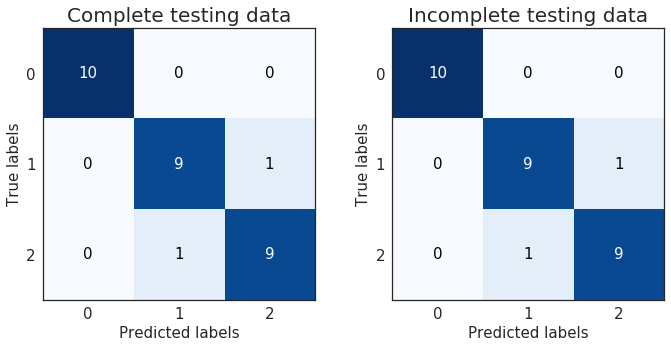

In [14]:

fig, axes = plt.subplots(ncols=2, figsize=(10,5))

mpl_utils.plot_confusion_matrix(confusion_matrix_complete, axes[0], show_colorbar=False, title="Complete testing data")
mpl_utils.plot_confusion_matrix(confusion_matrix_complete, axes[1], show_colorbar=False, title="Incomplete testing data")

In [ ]:
from autosklearn.pipeline.regression import SimpleRegressionPipeline as SRP

In [ ]:
from autosklearn.pipeline.classification import SimpleClassificationPipeline as SCP

In [ ]:
orig_get_pipeline = SCP._get_pipeline
orig_srp_pipeline = SRP._get_pipeline

In [ ]:
SCP._get_pipeline = get_classification_knn_pipeline

In [ ]:
classifier = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=30,
    initial_configurations_via_metalearning=0
)

In [ ]:
classifier.

In [ ]:
classifier_fit = classifier.fit(data.X_incomplete_train, data.y_train)

In [ ]:
import automlutils.automl_utils as automl_utils

In [ ]:
import automlutils.autosklearn_wrapper as asw

In [ ]:
ensemble = asw._extract_autosklearn_ensemble(classifier, estimtor_named_step="classifier")

In [ ]:
pipeline = ensemble[1][1]

In [ ]:
pipeline.named_steps

In [ ]:
from automlutils.autosklearn_wrapper import AutoSklearnWrapper

In [ ]:
confusion_matrix_incomplete

In [ ]:
confusion_matrix_complete

In [ ]:
mappable = ax.imshow(confusion_matrix_complete, interpolation='nearest', cmap=plt.cm.Blues)

In [ ]:
mappable.norm(20)

In [ ]:
fig, ax = plt.subplots()

y = data.y_test
x = y_pred_incomplete

ax.scatter(x, y, alpha=0.1)

In [ ]:
fig, ax = plt.subplots()

y = data.y_test
x = y_pred_incomplete

ax.scatter(x, y, alpha=0.1)